In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Returns Distribution

## Imports

In [39]:
import os
import numpy as np
# import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, laplace, gmean
from Scripts.update_data import update_daily_price_data_yahoo
from scipy.stats import gaussian_kde


## Update daily price data

In [40]:
asset = 'SPY'

update_daily_price_data_yahoo(asset)

,date,open,high,low,close,adjclose,volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,24.608639,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,24.783648,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,24.836159,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.098700,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.203720,531500
...,...,...,...,...,...,...,...
7973,2024-09-30,570.419983,574.380005,568.080017,573.760010,573.760010,63557400
7974,2024-10-01,573.400024,574.059998,566.000000,568.619995,568.619995,72668800
7975,2024-10-02,567.710022,569.900024,565.270020,568.859985,568.859985,38097800
7976,2024-10-03,567.359985,569.799988,565.489990,567.820007,567.820007,40846500


In [41]:
df = pl.read_csv(f'./Data/Daily_price_data/yahoo_finance/{asset}.csv')
df = df.with_columns(pl.col('date').str.to_date())
df

,date,open,high,low,close,adjclose,volume
i64,date,f64,f64,f64,f64,f64,i64
0,1993-01-29,43.96875,43.96875,43.75,43.9375,24.608639,1003200
1,1993-02-01,43.96875,44.25,43.96875,44.25,24.783648,480500
2,1993-02-02,44.21875,44.375,44.125,44.34375,24.836159,201300
3,1993-02-03,44.40625,44.84375,44.375,44.8125,25.0987,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.0,25.20372,531500
…,…,…,…,…,…,…,…
7973,2024-09-30,570.419983,574.380005,568.080017,573.76001,573.76001,63557400
7974,2024-10-01,573.400024,574.059998,566.0,568.619995,568.619995,72668800
7975,2024-10-02,567.710022,569.900024,565.27002,568.859985,568.859985,38097800


## Histogram of returns

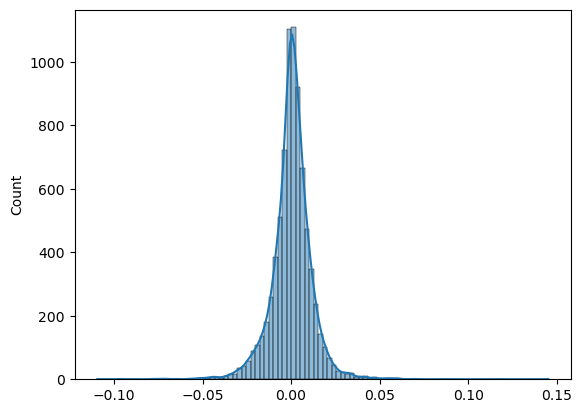

In [42]:
df = df.with_columns(
    (pl.col('close').pct_change()).alias('daily return')
)
df = df.drop_nulls()

sns.histplot(df['daily return'], bins=100, kde=True)
plt.show()

## Normal Distribution

Mean    : 0.00039131181027047255
Vol     : 0.01176893120777463


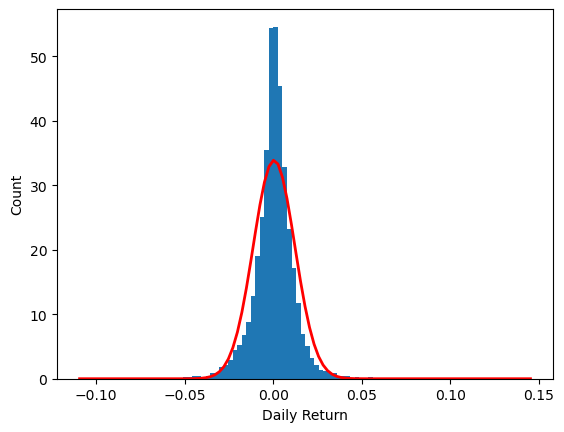

In [43]:
# Fit normal distribution

norm_params = norm.fit(df['daily return'])
print(f'Mean    : {norm_params[0]}')
print(f'Vol     : {norm_params[1]}')

count, bins, ignored = plt.hist(df['daily return'], 100, density=True)
mu, sigma = norm_params
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.xlabel('Daily Return')
plt.ylabel('Count')
plt.show()

## Laplace Distribution

loc     :0.0006283911998622035
scale   :0.007843699603546365


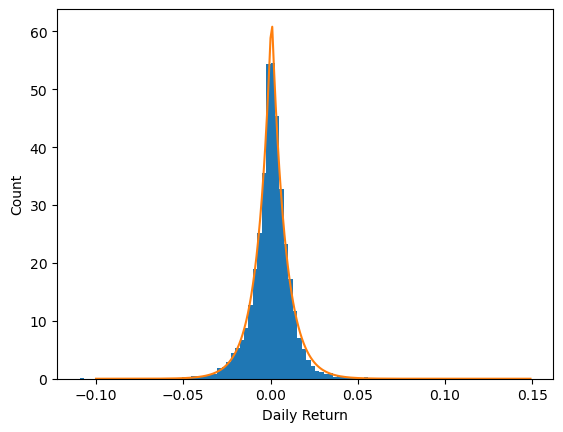

In [44]:
# Fit Laplace distribution parameters
laplace_params = laplace.fit(df['daily return'])
print(f'loc     :{laplace_params[0]}')
print(f'scale   :{laplace_params[1]}')

# Plot daily returns distribution
count, bins, ignored = plt.hist(df['daily return'], 100, density=True)

# Plot Laplace distribution with parameters
loc, scale = laplace_params
# monte_carlo_samples = laplace.rvs(loc=loc, scale=scale, size=num_samples)

x = np.arange(-0.1, 0.15, .001)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)
plt.xlabel('Daily Return')
plt.ylabel('Count')
plt.show()

## Kernel Density Estimate

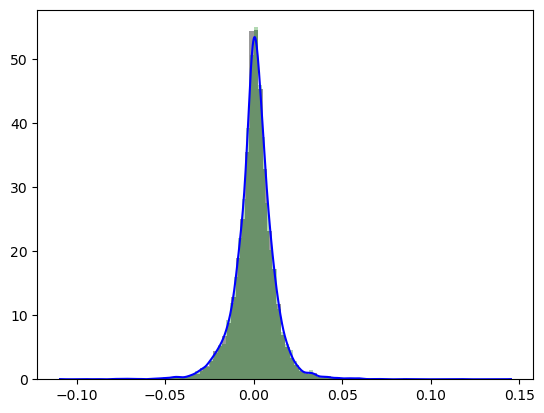

In [45]:
kde = gaussian_kde(df['daily return'])
num_samples = 10000
monte_carlo_samples = kde.resample(num_samples)[0]

x_vals = np.linspace(min(df['daily return']), max(df['daily return']), 1000)
kde_vals = kde(x_vals)

# plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_vals, color='blue', label='KDE Distribution')
plt.hist(df['daily return'], bins=100, density=True, alpha=0.4, color='black', label='Original Sample')
plt.hist(monte_carlo_samples, bins=100, density=True, alpha=0.3, color='green', label='Monte Carlo Samples')
plt.show()